In [1]:
import numpy as np
from math import sqrt
from matplotlib.image import NonUniformImage
import matplotlib.pyplot as plt
%matplotlib inline
from statistics import mean
from scipy.stats import norm
from scipy.stats import lognorm
import seaborn as sns
sns.set()
sns.set_style('white')

In [3]:
#load file, skip header, load angles and coordinates
raw_data = np.loadtxt('Raw Data/AZ31B Ecomp 10e0 Int_3 raw1.txt', skiprows=17, usecols=(0,1,2,3,4))
grain_IDs=np.loadtxt('Raw Data/AZ31B Ecomp 10e0 Int_3 raw1.txt', skiprows=17, usecols=(8))

In [20]:
#prevent algorithm from reading empty rows, make fix later
data_subset=raw_data[0:87000]
data_random=data_subset[np.random.choice(data_subset.shape[0], 85000, replace=False)]
data=data_random

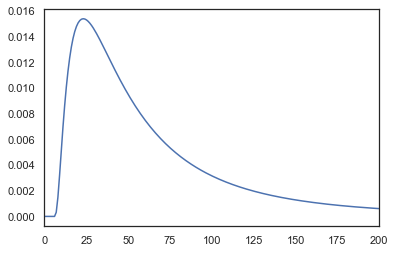

In [22]:
#use all the rows to make a lognorm pdf
uniquegrains=np.unique(grain_IDs,return_counts=True)
ID, count = uniquegrains
#print(mean(count))
#normalize, divide all grains by total number of grains
# norm_count=count/(len(count))
# print(mean(norm_count))
#grains = dict(zip(ID, count)) 
params = lognorm.fit(count)
xvals = np.linspace(0, 200, num=200)
pdf = lambda x: lognorm.pdf(xvals, *params)
t = pdf(xvals)
#remove 0 values to prevent KL error
t[t==0]=[0.000001]
plt.xlim(0, 200)
plt.plot(xvals, t)

In [23]:
import math
import numpy as np

#https://en.wikipedia.org/wiki/Misorientation
euler_one=[math.radians(90),math.radians(35),math.radians(45)] #copper
euler_two=[math.radians(59),math.radians(37),math.radians(63)] #S3
#phi1, PHI, phi2

def misorientation(euler_one, euler_two):
    #orientation matrices
    g_one=np.array([[((math.cos(euler_one[0]))*(math.cos(euler_one[2]))-(math.sin(euler_one[0]))*(math.sin(euler_one[2]))*(math.cos(euler_one[1]))),((math.sin(euler_one[0]))*(math.cos(euler_one[2]))+(math.cos(euler_one[0]))*(math.sin(euler_one[2]))*(math.cos(euler_one[1]))),((math.sin(euler_one[2]))*(math.sin(euler_one[1])))],
                [(-(math.cos(euler_one[0]))*(math.sin(euler_one[2]))-(math.sin(euler_one[0]))*(math.cos(euler_one[2]))*(math.cos(euler_one[1]))),(-(math.sin(euler_one[0]))*(math.sin(euler_one[2]))+(math.cos(euler_one[0]))*(math.cos(euler_one[2]))*(math.cos(euler_one[1]))),((math.cos(euler_one[2]))*(math.sin(euler_one[1])))],
                [((math.sin(euler_one[0]))*(math.sin(euler_one[1]))),(-(math.cos(euler_one[0]))*(math.sin(euler_one[1]))),(math.cos(euler_one[1]))]        
                ])
   
    #euler_two
    g_two=np.array([[((math.cos(euler_two[0]))*(math.cos(euler_two[2]))-(math.sin(euler_two[0]))*(math.sin(euler_two[2]))*(math.cos(euler_two[1]))),((math.sin(euler_two[0]))*(math.cos(euler_two[2]))+(math.cos(euler_two[0]))*(math.sin(euler_two[2]))*(math.cos(euler_two[1]))),((math.sin(euler_two[2]))*(math.sin(euler_two[1])))],
                [(-(math.cos(euler_two[0]))*(math.sin(euler_two[2]))-(math.sin(euler_two[0]))*(math.cos(euler_two[2]))*(math.cos(euler_two[1]))),(-(math.sin(euler_two[0]))*(math.sin(euler_two[2]))+(math.cos(euler_two[0]))*(math.cos(euler_two[2]))*(math.cos(euler_two[1]))),((math.cos(euler_two[2]))*(math.sin(euler_two[1])))],
                [((math.sin(euler_two[0]))*(math.sin(euler_two[1]))),(-(math.cos(euler_two[0]))*(math.sin(euler_two[1]))),(math.cos(euler_two[1]))]        
                ])
    
    #misorientation matrix
    delta_g=np.dot(g_one,np.linalg.inv(g_two))
                     
    
    #misorientation angle
    #error handling for rounding errors outside of domain
    try:
        theta=math.acos((delta_g[0,0]+delta_g[1,1]+delta_g[2,2]-1)/2)
    except:
        if (((delta_g[0,0]+delta_g[1,1]+delta_g[2,2]-1)/2)>1):
            theta=0
        else:
            theta=180

    return math.degrees(theta)

#test function with known calculation
# print(misorientation(euler_one,euler_two))

In [24]:
from collections import defaultdict

#build function

grains = defaultdict(list)
row_array=[]
row_list=()
new_key=1
euler_one=[0,0,0]
euler_two=[0,0,0]

distance_threshold=80000
angle_threshold=5

#add keys to prevent none return
#while x < 5000:
    
#or randomly initialize?

#is the pixel in the grains dictionary
def indict(row):
    for key in grains:
        #print(key)
        row_array=grains[key]
        row_list=list(row_array) 
        euler_one=[row[0],row[1],row[2]]
        #raises error if value for key does not exist, how to handle? 
        euler_two=[row_list[0][0],row_list[0][1],row_list[0][2]]
        if (misorientation(euler_one,euler_two)<5) and (sqrt((row[3]-row_list[0][3])**2+(row[4]-row_list[0][4])**2)<distance_threshold):
            #print('True')
            return True, key
        else:
            #print('continue')
            continue
    return False,key
              
#dictionary starting value
row_array=data[0]
row_list=list(row_array)
grains[0].append(row_list)
 
    
#use zip?
for row in data: 
    #print(row)
    truu, keey = indict(row)
    if truu is True:
        row_list=list(row)
        grains[keey].append(row_list) 
#         print('new pixel')
#         print(grains)
    if truu is False:
        row_list=list(row)
        grains[keey+1].append(row_list)
#         print('new grain')
#         print(grains)

#doesn't know when to stop
    
print(len(grains))

KeyboardInterrupt: 

In [ ]:
count=[]
for key in grains:
    count.append(len(grains[key]))

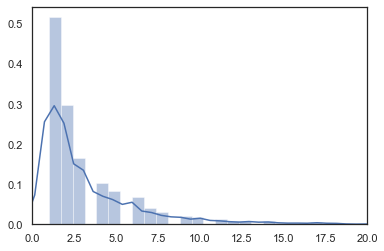

In [19]:
plt.xlim(0, 20)
sns.distplot(count, bins=100)
#clusters too small due to distance parameter
# from statistics import mean
# print(mean(count))

In [ ]:
#d=10, mean = 2.7
#d=100&30, mean =3
#d=283, mean = 3.5 
#80000,3.5

In [ ]:
#normalize, create grid of x and y values, find other method to compute size, difference in pdfs (all vs some)
#difference in shape likely due to only comparing first member of grain, biases toward smaller grain sizes
#use normalization by area if you want a histogram to approximate a pdf, but it's already being fitted, so divide by sample size